# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Pre-processing
import missingno as mn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Simple Models
from sklearn.linear_model import LogisticRegression

# Tree Models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model

# Metrics
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, balanced_accuracy_score

# Preservation
import pickle


# Load Data

In [2]:
def load_data():
    weeks = list(range(1, 18))
    for week in weeks:
        path=f'./data/subset/web/week_{week}.csv'
        data = pd.read_csv(path, compression='zip')

        yield data

In [3]:
data = load_data()
data = list(data)
data = pd.concat(data, ignore_index=True)

Loading a larger data set to make predictions on all receivers, not just the targeted receiver that the model was trained on.

In [4]:
data['position'].unique()

array(['SS', 'FS', 'MLB', 'CB', 'LB', 'QB', 'WR', 'RB', 'TE', 'FB', nan,
       'OLB', 'ILB', 'DB', 'HB', 'DL', 'NT', 'S', 'DE', 'P', 'LS', 'K',
       'DT'], dtype=object)

# Pre-processing

Select only offensive rows

In [5]:
data = data.loc[data['possession'] == 1]
data = data.loc[data['position'] != 'LS']
data = data.loc[data['position'] != 'DL']
data = data.loc[data['position'] != 'ILB']
data = data.loc[data['position'] != 'FS']
data = data.loc[data['position'] != 'SS']
data = data.loc[data['position'] != 'OLB']
data = data.loc[data['position'] != 'S']
data = data.loc[data['position'] != 'NT']
data = data.loc[data['position'] != 'MLB']
data.reset_index(drop=True, inplace=True)
data.shape

(4383763, 35)

Thats a lot of rows!

Check for missing values

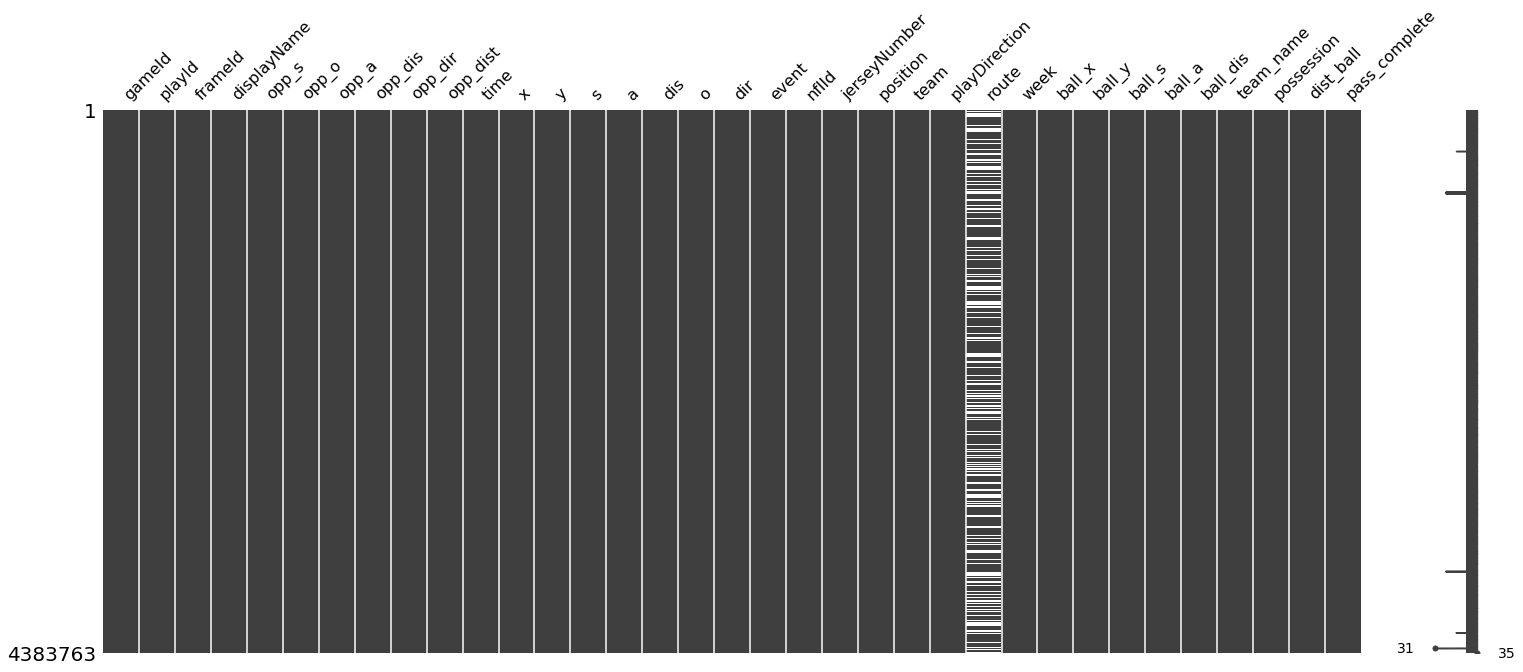

In [6]:
mn.matrix(data);

In [7]:
data.isna().sum()

gameId                 0
playId                 0
frameId                0
displayName            0
opp_s                  0
opp_o                 28
opp_a                  0
opp_dis                0
opp_dir               27
opp_dist               0
time                   0
x                      0
y                      0
s                      0
a                      0
dis                    0
o                     14
dir                    7
event                  0
nflId                  0
jerseyNumber           0
position               0
team                   0
playDirection          0
route            1187154
week                   0
ball_x                 0
ball_y                 0
ball_s                 6
ball_a               168
ball_dis               6
team_name              0
possession             0
dist_ball              0
pass_complete          0
dtype: int64

Impute missing values. Very few, in the grand scheme of things.

In [8]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
data[['opp_o', 'opp_dir', 'o', 'dir', 'ball_a', 'ball_dis', 'ball_s']] = imp_mean.fit_transform(data[['opp_o', 'opp_dir', 'o', 'dir', 'ball_a', 'ball_dis', 'ball_s']])
data['route'].fillna('None', inplace=True)

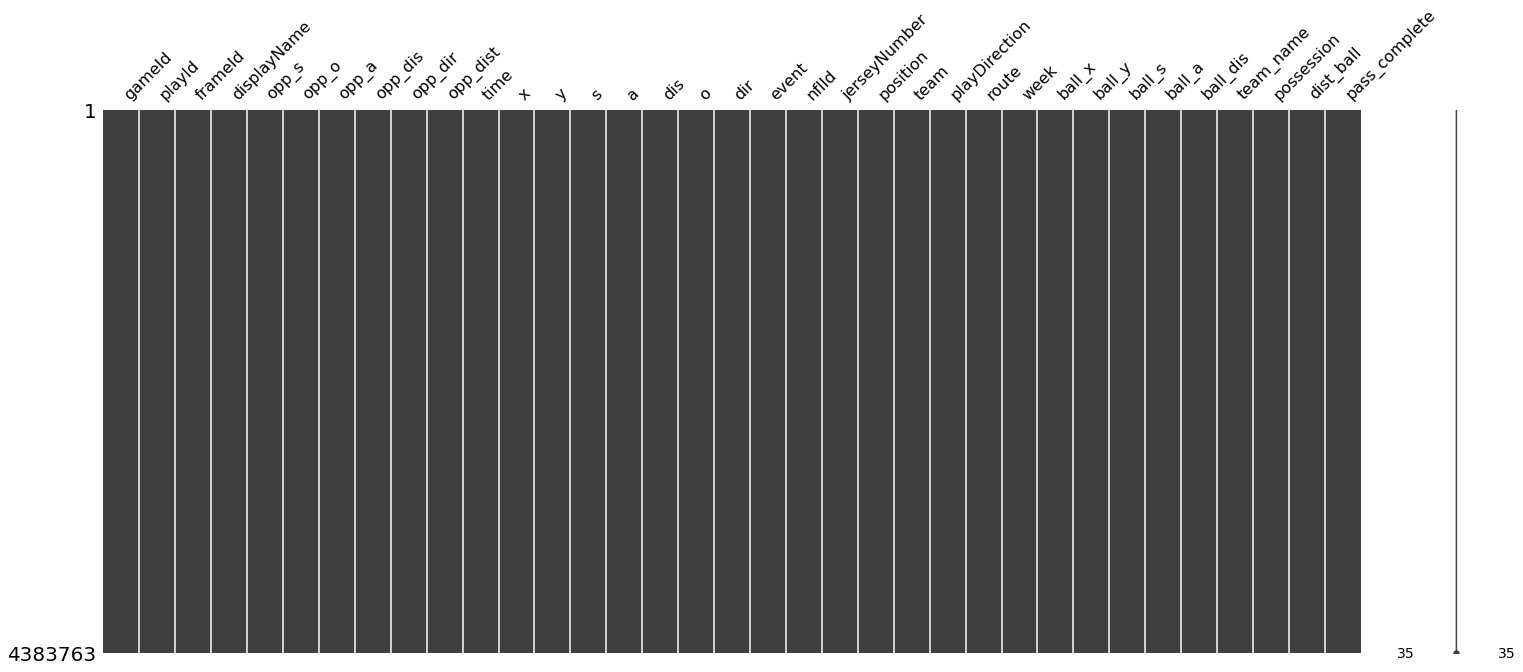

In [9]:
mn.matrix(data);

All missing values accounted for.

In [10]:
data.isna().sum().sum()

0

# Load Models

In [11]:
path = './models/features.pkl'
with open(path, 'rb') as f:
    features = pickle.load(f)

path = './models/random_forest.pkl'
with open(path, 'rb') as f:
    rf = pickle.load(f)

path = './models/extra_trees.pkl'
with open(path, 'rb') as f:
    xt = pickle.load(f)

path = './models/scaler.pkl'
with open(path, 'rb') as f:
    sc = pickle.load(f)

path = './models/neural_net.keras'
model = load_model(path)

2022-03-19 13:42:53.753764: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
X = data.loc[:,features].copy()

In [13]:
dummy_vars = pd.get_dummies(X[['route']])
X.drop(columns=['route'], inplace=True)
X = pd.concat([X, dummy_vars], axis=1)
X.reset_index(drop=True, inplace=True)
X['x'] = X['x'].map(lambda x: 0 if x<0 else x)
X.head()

,dist_ball,x,y,s,a,opp_dist,opp_s,opp_a,route_ANGLE,route_CORNER,...,route_GO,route_HITCH,route_IN,route_None,route_OUT,route_POST,route_SCREEN,route_SLANT,route_WHEEL,route_undefined
0,1.81,91.74,26.67,0.0,0.00,6.040530,0.01,0.02,0,0,...,0,0,0,1,0,0,0,0,0,0
1,18.54,91.36,44.14,0.0,0.01,7.472858,0.06,0.05,0,0,...,0,1,0,0,0,0,0,0,0,0
2,9.98,90.78,36.16,0.0,0.00,1.920339,0.01,0.01,0,0,...,0,1,0,0,0,0,0,0,0,0
3,8.37,98.25,26.62,0.0,0.00,12.460915,0.07,0.07,0,0,...,0,0,0,1,0,0,0,0,0,0
4,6.19,91.30,21.85,0.0,0.01,4.833353,0.18,0.07,0,0,...,0,0,0,0,1,0,0,0,0,0


## Scale

In [14]:
X_sc = sc.transform(X)

## Ensemble Model

In [15]:
ens_models = {
    'Random Forest': rf,
    'Extra Trees': xt,
    'Neural Net': model
}

In [16]:
def ens_pred(models):

    # Neural Net
    nn_pred = models['Neural Net'].predict(X_sc)
    nn_pred = nn_pred.flatten()

    # Random Forest
    rf_pred = models['Random Forest'].predict_proba(X_sc)[:,1]
    
    # Extra Trees
    xt_pred = models['Extra Trees'].predict_proba(X_sc)[:,1]

    ensemble_preds = pd.concat([
    pd.DataFrame(rf_pred),
    pd.DataFrame(xt_pred),
    pd.DataFrame(nn_pred),
    ], axis=1).mean(axis=1)

    return ensemble_preds

Calculate the ensemble prediction by combining the random forest, extra tree, and neural network probabilities.

In [17]:
preds = ens_pred(ens_models)

Preservation

In [18]:
data['preds'] = preds

In [19]:
export = data[['gameId', 'playId', 'frameId', 'event', 'displayName', 'position', 'x', 'y', 'preds', 'team', 'pass_complete']]
export

,gameId,playId,frameId,event,displayName,position,x,y,preds,team,pass_complete
0,2018090600,75,11,ball_snap,Matt Ryan,QB,91.74,26.67,0.457552,away,1
1,2018090600,75,11,ball_snap,Julio Jones,WR,91.36,44.14,0.578130,away,1
2,2018090600,75,11,ball_snap,Mohamed Sanu,WR,90.78,36.16,0.474055,away,1
3,2018090600,75,11,ball_snap,Devonta Freeman,RB,98.25,26.62,0.474567,away,1
4,2018090600,75,11,ball_snap,Austin Hooper,TE,91.30,21.85,0.540093,away,1
...,...,...,...,...,...,...,...,...,...,...,...
4383758,2018123011,4261,53,pass_outcome_interception,Dion Lewis,RB,84.33,32.32,0.593227,home,0
4383759,2018123011,4261,53,pass_outcome_interception,Darius Jennings,WR,74.43,22.50,0.634755,home,0
4383760,2018123011,4261,53,pass_outcome_interception,Taywan Taylor,WR,68.90,48.65,0.590423,home,0
4383761,2018123011,4261,53,pass_outcome_interception,Anthony Firkser,TE,64.43,23.20,0.658256,home,0


Export the predictions to merge into the cleaned data for web app and QB-iQ calculations.

In [20]:
path = './models/ens_predictions.pkl'
with open(path, 'wb') as f:
    pickle.dump(export, f)